In [137]:
import numpy as np
from numpy.random import random, randint, randn
from scipy.integrate import quad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulation

In [2]:
def init_prior():
    # [blue, purple (not blue)]
    return np.array([1., 1.])


def init_prior_1000():
    return np.array([1000., 1000.])


def init_prior_800():
    return np.array([800., 800.])


def update_rule_1(report):
    # Ideal Bayesian observer
    if report:
        # See blue, update blue
        return np.array([1., 0.])
    else:
        # See purple, update purple
        return np.array([0., 1.])


def update_rule_2(report):
    # Signal search
    if report:
        # See blue, update blue
        return np.array([1., 0.])
    else:
        # See purple, update purple
        return np.array([0., 0.])


def update_rule_3(report):
    # Twisted observer 1
    if report:
        return np.array([0., 1.])
    else:
        return np.array([1., 0.])


def update_rule_4(report):
    # Twisted observer 2
    if report:
        # See blue, takeout blue
        return np.array([-1., 0.])
    else:
        return np.array([0., -1.])

In [4]:
# Helpers
def ex(s, x, sig):
    return np.exp(-(s - x)**2 / (2 * sig**2))


def pick_class(blue_p):
    return 1 if random() < blue_p else -1


def pick_stimulus(cls, a):
    # cls blue 1 purple -1
    return cls * randint(a + 1)

In [50]:
global_observer_id = 0

In [51]:
class Observer:
    def __init__(self, init_p, update_rule, sig):
        global global_observer_id
        self.init_p = init_p
        self.update_rule = update_rule

        self.prior = init_p()
        self.sig = sig
        self.reports = []
        self.id = global_observer_id
        global_observer_id += 1

    def make_observation(self, s):
        return self.sig * randn() + s

    def report_observation(self, m):
        # Report True if blue (> 0) or False if purple
        if m < -a: return False
        if m > a: return True
        q1 = quad(lambda s: ex(s, m, self.sig), 0, a)[0]
        q2 = quad(lambda s: ex(s, m, self.sig), -a, 0)[0]
        if q1 and q2:
            return 0 < np.log(self.prior[0] / self.prior[1]) + np.log(q1 / q2)
        elif q1 and not q2:
            return True
        else:
            return False

    def update_prior(self, report):
        self.prior += self.update_rule(report)
        # if not self.prior[0]: self.prior[0] = 1.
        # if not self.prior[1]: self.prior[1] = 1.

    def do(self, stimulus, session, trial):
        # Do the experiment for one trial
        r = {'s': stimulus, 'session': session, 'trial': trial, 'id': self.id}
        r['corr_r'] = 1 if r['s'] > 0 else 0  # Correct answer
        if self.report_observation(self.make_observation(stimulus)):
            # blue
            r['r'] = 1
            self.update_prior(True)
        else:
            # purple
            r['r'] = 0
            self.update_prior(False)
        r['prior_b'] = self.prior[0]
        r['prior_p'] = self.prior[1]
        self.reports.append(r)

    def summary(self):
        self.df = pd.DataFrame(self.reports)

    def reset(self):
        self.prior = self.init_p()

## Study 1

In [55]:
# Color scaler bonds [-50, 50]
a = 50
sessions = 70
trials = 1000

In [32]:
def generate_class_probabilities(ps, cutoffs):
    # ps - blue
    probabilities = []
    for c in range(len(cutoffs)):
        probabilities += [ps[c]] * (cutoffs[c] if c == 0 else cutoffs[c] -
                                    cutoffs[c - 1])
    return np.array(probabilities)

In [56]:
%%capture --no-display

observers_1 = [[Observer(init_prior, update_rule_1, 9) for x in range(2)],
               [Observer(init_prior, update_rule_2, 9) for x in range(2)],
               [Observer(init_prior, update_rule_3, 9) for x in range(2)],
               [Observer(init_prior_1000, update_rule_4, 9) for x in range(2)]]

condition_probabilities_1 = [
    generate_class_probabilities([.5], [1000]),
    generate_class_probabilities([.5, .4, .28, .16, .06],
                                 [200, 250, 300, 350, 1000])
]

for se in range(sessions):
    for rule in range(4):
        observers_1[rule][0].reset()
        observers_1[rule][1].reset()
        for t in range(trials):
            s_const = pick_stimulus(
                pick_class(condition_probabilities_1[0][t]), a)
            s_de = pick_stimulus(pick_class(condition_probabilities_1[1][t]),
                                 a)

            observers_1[rule][0].do(s_const, se, t)
            observers_1[rule][1].do(s_de, se, t)

for r in range(len(observers_1)):
    for o in range(len(observers_1[r])):
        observers_1[r][o].summary()
        observers_1[r][o].df.to_csv(f'data/study1/std1_hyp{r}_cond{o}.csv')

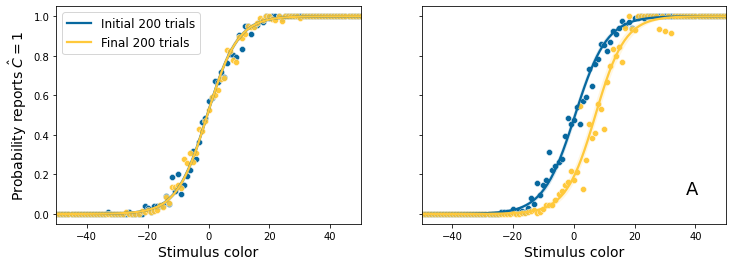

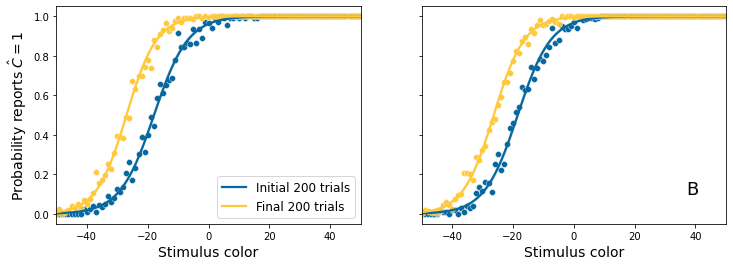

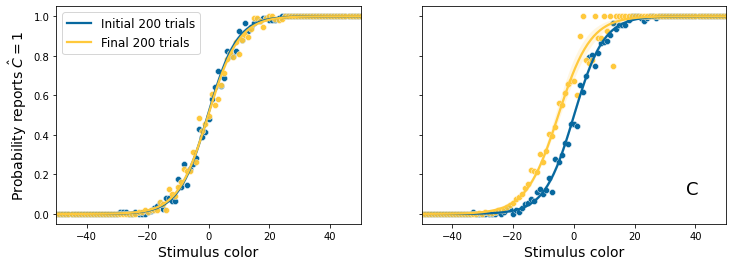

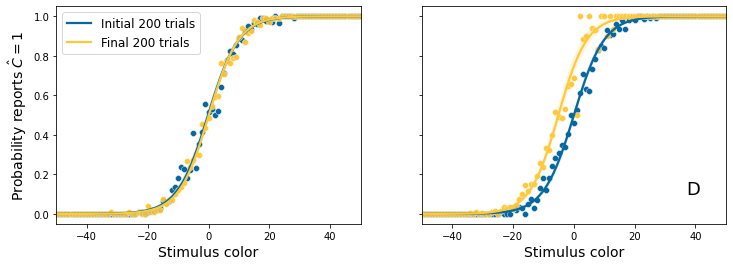

In [35]:
for r in range(len(observers_1)):
    for o in observers_1[r]:
        o.summary()
    plot_by_rule(observers_1[r], r)

## Study 4

In [10]:
# Color scaler bonds [-50, 50]
a = 50
sessions = 50
trials = 800

In [57]:
%%capture --no-display

observers_4 = [[Observer(init_prior, update_rule_1, 9) for x in range(3)],
               [Observer(init_prior, update_rule_2, 9) for x in range(3)],
               [Observer(init_prior, update_rule_3, 9) for x in range(3)],
               [Observer(init_prior_800, update_rule_4, 9) for x in range(3)]]

condition_probabilities = [
    generate_class_probabilities([.5], [800]),
    generate_class_probabilities([.5, .4, .28, .16, .06],
                                 [200, 250, 300, 350, 800]),
    generate_class_probabilities([.5, .06], [200, 800])
]

for se in range(sessions):
    for rule in range(4):
        observers_4[rule][0].reset()
        observers_4[rule][1].reset()
        observers_4[rule][2].reset()
        for t in range(800):
            s_1 = pick_stimulus(pick_class(condition_probabilities[0][t]), a)
            s_2 = pick_stimulus(pick_class(condition_probabilities[1][t]), a)
            s_3 = pick_stimulus(pick_class(condition_probabilities[2][t]), a)

            observers_4[rule][0].do(s_1, se, t)
            observers_4[rule][1].do(s_2, se, t)
            observers_4[rule][2].do(s_3, se, t)

for r in range(len(observers_4)):
    for o in range(len(observers_4[r])):
        observers_4[r][o].summary()
        observers_4[r][o].df.to_csv(f'data/study4/std4_hyp{r}_cond{o}.csv')

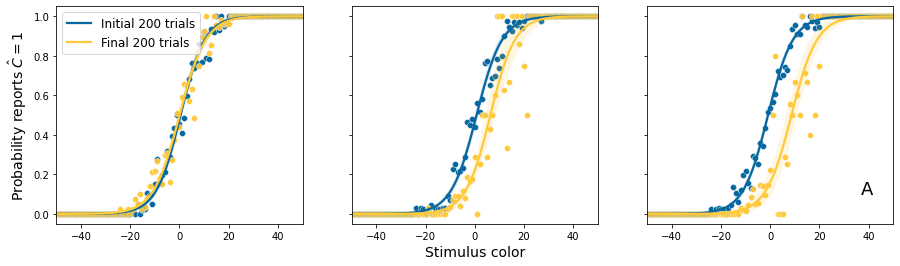

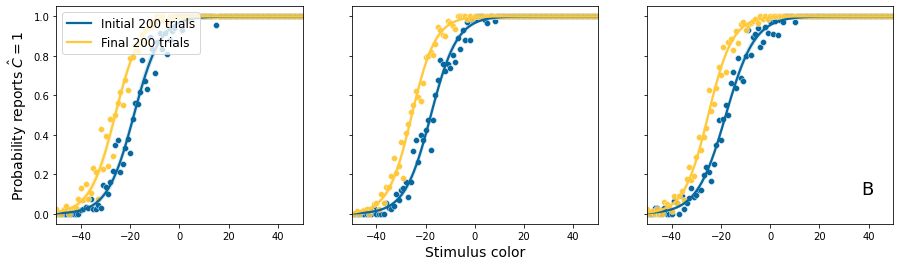

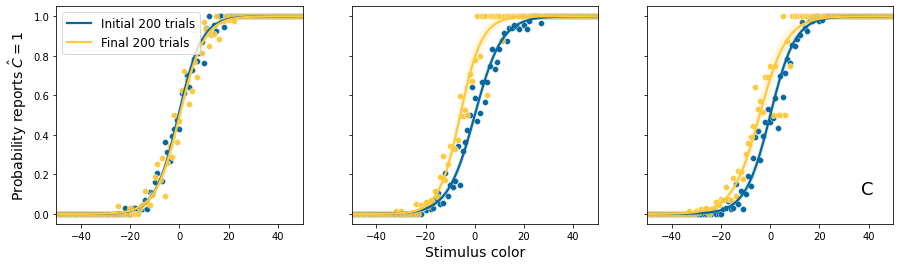

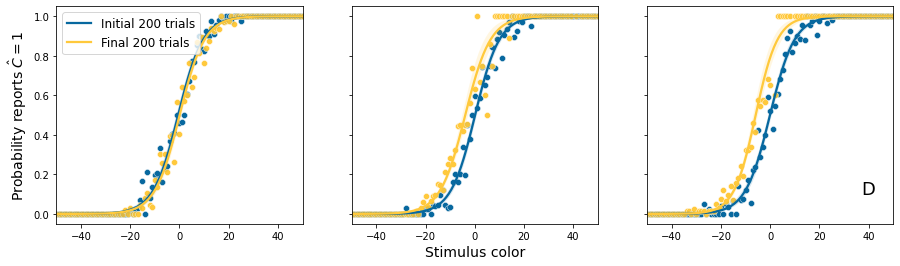

In [13]:
for r in range(len(observers)):
    for o in observers[r]:
        o.summary()
    plot_by_rule_3obs(observers[r], r)

## Study 5

In [14]:
# Color scaler bonds [-50, 50]
a = 50
sessions = 50
trials = 1000

In [58]:
%%capture --no-display

observers_5 = [[Observer(init_prior, update_rule_1, 9) for x in range(2)],
               [Observer(init_prior, update_rule_2, 9) for x in range(2)],
               [Observer(init_prior, update_rule_3, 9) for x in range(2)],
               [Observer(init_prior_1000, update_rule_4, 9) for x in range(2)]]

condition_probabilities_5 = [
    generate_class_probabilities([.5], [1000]),
    generate_class_probabilities([.06, .16, .28, .40, .50],
                                 [200, 250, 300, 350, 1000])
]

for se in range(sessions):
    for rule in range(4):
        observers_5[rule][0].reset()
        observers_5[rule][1].reset()
        for t in range(trials):
            s_1 = pick_stimulus(pick_class(condition_probabilities_5[0][t]), a)
            s_2 = pick_stimulus(pick_class(condition_probabilities_5[1][t]), a)

            observers_5[rule][0].do(s_1, se, t)
            observers_5[rule][1].do(s_2, se, t)

for r in range(len(observers_5)):
    for o in range(len(observers_5[r])):
        observers_5[r][o].summary()
        observers_5[r][o].df.to_csv(f'data/study5/std5_hyp{r}_cond{o}.csv')

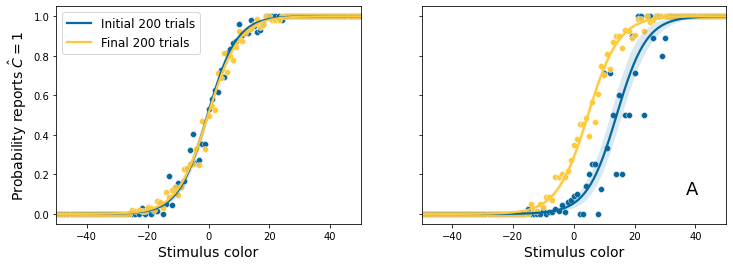

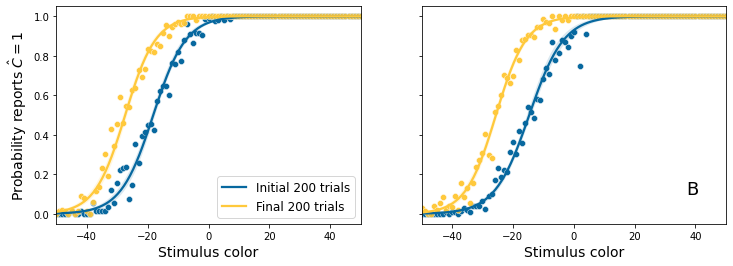

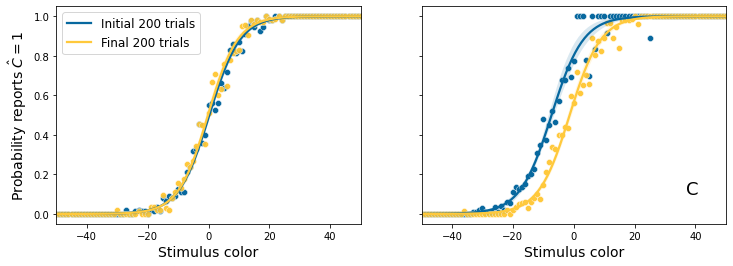

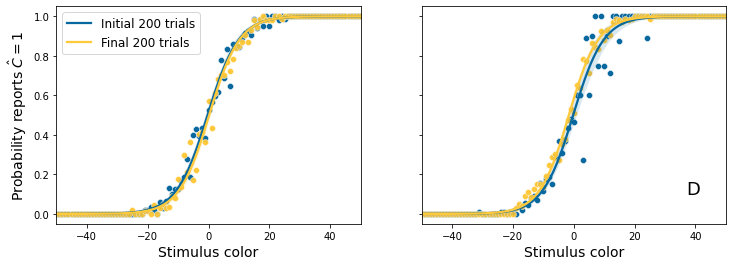

In [16]:
for r in range(len(observers_5)):
    for o in observers_5[r]:
        o.summary()
    plot_by_rule(observers_5[r], r)

## New Study

In [17]:
# Color scaler bonds [-50, 50]
a = 50
sessions = 20
trials = 1000

In [59]:
%%capture --no-display

observers_x = [[Observer(init_prior, update_rule_1, 9) for x in range(2)],
               [Observer(init_prior, update_rule_2, 9) for x in range(2)],
               [Observer(init_prior, update_rule_3, 9) for x in range(2)],
               [Observer(init_prior_1000, update_rule_4, 9) for x in range(2)]]

condition_probabilities_x = [
    generate_class_probabilities([.2], [1000]),
    generate_class_probabilities([.5, .4, .28, .16, .06],
                                 [200, 250, 300, 350, 1000])
]

for se in range(sessions):
    for rule in range(4):
        observers_x[rule][0].reset()
        observers_x[rule][1].reset()
        for t in range(trials):
            s_const = pick_stimulus(
                pick_class(condition_probabilities_x[0][t]), a)
            s_de = pick_stimulus(pick_class(condition_probabilities_x[1][t]),
                                 a)

            observers_x[rule][0].do(s_const, se, t)
            observers_x[rule][1].do(s_de, se, t)

for r in range(len(observers_x)):
    for o in range(len(observers_x[r])):
        observers_x[r][o].summary()
        observers_x[r][o].df.to_csv(f'data/studyn/stdn_hyp{r}_cond{o}.csv')

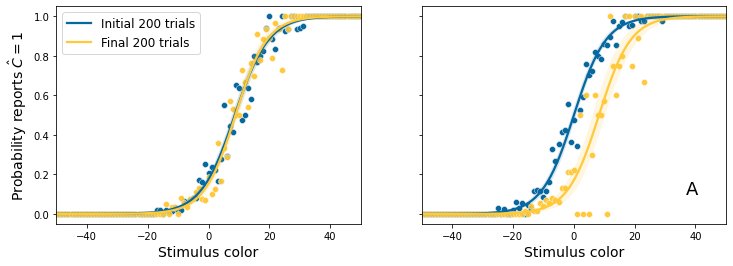

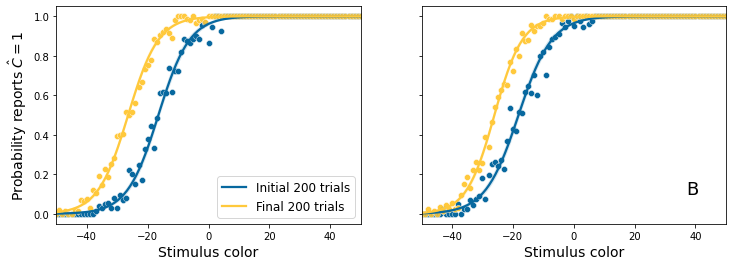

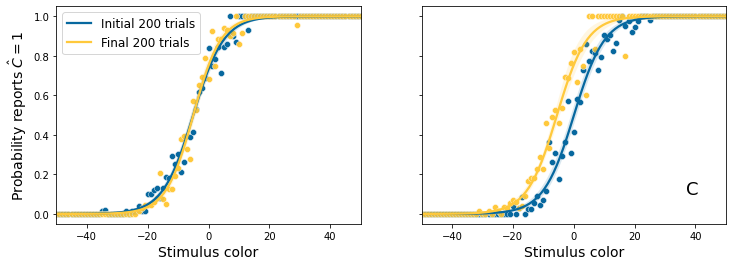

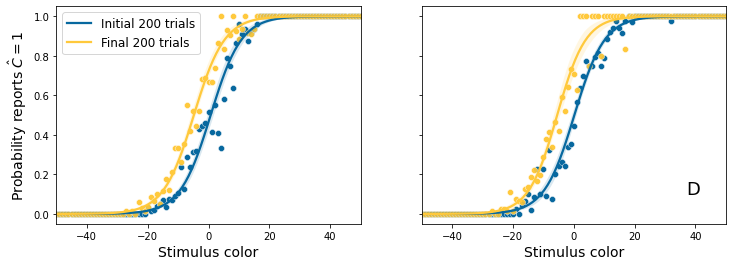

In [19]:
for r in range(len(observers_x)):
    for o in observers_x[r]:
        o.summary()
    plot_by_rule(observers_x[r], r)

# Analysis

In [76]:
def plot_by_rule(obs_all, r_num):
    fig1, axs = plt.subplots(1,
                             2,
                             figsize=(12, 3),
                             sharey=True,
                             sharex=True,
                             dpi=72)
    ax_ind = 0
    alphas = ['A', 'B', 'C', 'D']  # Rule label
    for obs in obs_all:
        first = obs.df[obs.df['trial'] < 200].groupby('s')['r'].mean()
        last = obs.df[obs.df['trial'] >= 800].groupby('s')['r'].mean()
        sns.scatterplot(data=first, color='#07689f', ax=axs[ax_ind])
        sns.scatterplot(data=last, color='#ffc93c', ax=axs[ax_ind])
        sns.regplot(x=first.index,
                    y=first,
                    data=first,
                    logistic=True,
                    color='#07689f',
                    ax=axs[ax_ind],
                    scatter_kws={'alpha': 0.05})
        sns.regplot(x=last.index,
                    y=last,
                    data=last,
                    logistic=True,
                    color='#ffc93c',
                    ax=axs[ax_ind],
                    scatter_kws={'alpha': 0.05})
        axs[ax_ind].set_xlabel('Stimulus color', fontsize=14)
        ax_ind += 1
    axs[0].legend(('Initial 200 trials', 'Final 200 trials'), fontsize=12)
    axs[0].set_ylabel(r'Probability reports $\hat{C}=1$', fontsize=14)
    axs[1].text(37, .1, f'{alphas[r_num]}', fontsize=18)

    plt.show()

In [12]:
def plot_by_rule_3obs(obs_all, r_num):
    fig1, axs = plt.subplots(1,
                             3,
                             figsize=(15, 4),
                             sharey=True,
                             sharex=True,
                             dpi=72)
    ax_ind = 0
    alphas = ['A', 'B', 'C', 'D']
    for obs in obs_all:
        first = obs.df[obs.df['trial'] < 200].groupby('s')['r'].mean()
        last = obs.df[obs.df['trial'] >= 600].groupby('s')['r'].mean()
        sns.scatterplot(data=first, color='#07689f', ax=axs[ax_ind])
        sns.scatterplot(data=last, color='#ffc93c', ax=axs[ax_ind])
        sns.regplot(x=first.index,
                    y=first,
                    data=first,
                    logistic=True,
                    color='#07689f',
                    ax=axs[ax_ind],
                    scatter_kws={'alpha': 0.05})
        sns.regplot(x=last.index,
                    y=last,
                    data=last,
                    logistic=True,
                    color='#ffc93c',
                    ax=axs[ax_ind],
                    scatter_kws={'alpha': 0.05})
        ax_ind += 1
    axs[0].legend(('Initial 200 trials', 'Final 200 trials'),
                  fontsize=12,
                  loc='upper left')
    axs[0].set_ylabel(r'Probability reports $\hat{C}=1$', fontsize=14)
    axs[0].set_xlabel('')
    axs[1].set_xlabel('Stimulus color', fontsize=14)
    axs[2].set_xlabel('')
    axs[2].text(37, .1, f'{alphas[r_num]}', fontsize=18)

    plt.show()

In [60]:
import os

In [68]:
filenames = []
for std_name in ['1', '4', '5', 'n']:
    for name in os.listdir(f'data/study{std_name}'):
        filenames.append(f"data/study{std_name}/{name}")
filenames

['data/study1/std1_hyp0_cond0.csv',
 'data/study1/std1_hyp0_cond1.csv',
 'data/study1/std1_hyp1_cond0.csv',
 'data/study1/std1_hyp1_cond1.csv',
 'data/study1/std1_hyp2_cond1.csv',
 'data/study1/std1_hyp2_cond0.csv',
 'data/study1/std1_hyp3_cond1.csv',
 'data/study1/std1_hyp3_cond0.csv',
 'data/study4/std4_hyp1_cond2.csv',
 'data/study4/std4_hyp1_cond0.csv',
 'data/study4/std4_hyp1_cond1.csv',
 'data/study4/std4_hyp0_cond2.csv',
 'data/study4/std4_hyp0_cond0.csv',
 'data/study4/std4_hyp0_cond1.csv',
 'data/study4/std4_hyp3_cond2.csv',
 'data/study4/std4_hyp3_cond1.csv',
 'data/study4/std4_hyp3_cond0.csv',
 'data/study4/std4_hyp2_cond2.csv',
 'data/study4/std4_hyp2_cond1.csv',
 'data/study4/std4_hyp2_cond0.csv',
 'data/study5/std5_hyp1_cond1.csv',
 'data/study5/std5_hyp1_cond0.csv',
 'data/study5/std5_hyp0_cond1.csv',
 'data/study5/std5_hyp0_cond0.csv',
 'data/study5/std5_hyp3_cond0.csv',
 'data/study5/std5_hyp3_cond1.csv',
 'data/study5/std5_hyp2_cond0.csv',
 'data/study5/std5_hyp2_cond

In [69]:
df = pd.concat([pd.read_csv(f) for f in filenames])
df.head()

,Unnamed: 0,s,session,trial,id,corr_r,r,prior_b,prior_p
0,0,-50,0,0,0,0,0,1.0,2.0
1,1,-14,0,1,0,0,0,1.0,3.0
2,2,-34,0,2,0,0,0,1.0,4.0
3,3,9,0,3,0,1,0,1.0,5.0
4,4,46,0,4,0,1,1,2.0,5.0


In [191]:
def plot_all(observers,
             fig_name,
             vert_count=4,
             starting_label=0,
             three_obs=False,
             ttrials=1000):
    alphas = ['A', 'B', 'C', 'D']  # Rule label
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)

    fig, axs = plt.subplots(vert_count,
                            3 if three_obs else 2,
                            figsize=(10, 12 if vert_count == 4 else 6),
                            sharey=True,
                            sharex=True,
                            dpi=150)
    axs = axs.flatten()
    ax_ind = 0
    for c in range(len(observers)):
        condition = observers[c]
        for obs in condition:
            first = obs.df[obs.df['trial'] < 200].groupby('s')['r'].mean()
            last = obs.df[obs.df['trial'] >= ttrials -
                          200].groupby('s')['r'].mean()
            # sns.scatterplot(data=first, color='#07689f', ax=axs[ax_ind])
            # sns.scatterplot(data=last, color='#ffc93c', ax=axs[ax_ind])
            sns.regplot(x=first.index,
                        y=first,
                        data=first,
                        logistic=True,
                        color='#07689f',
                        ax=axs[ax_ind],
                        scatter_kws={'alpha': 0.5})
            sns.regplot(x=last.index,
                        y=last,
                        data=last,
                        logistic=True,
                        color='#ffc93c',
                        ax=axs[ax_ind],
                        scatter_kws={'alpha': 0.5})
            axs[ax_ind].set_xlabel('Stimulus color', fontsize=14)
            axs[ax_ind].set_xlabel('')
            axs[ax_ind].set_ylabel('')
            axs[ax_ind].set_yticks([0, 0.25, 0.5, 0.75, 1])
            axs[ax_ind].set_yticklabels(['0', '', '.5', '', '1'])
            axs[ax_ind].set_xticks([-40, -20, 0, 20, 40])
            axs[ax_ind].set_xticklabels([-40, -20, 0, 20, 40])
            ax_ind += 1
        axs[0].legend(('Initial 200 trials', 'Final 200 trials'),
                      fontsize=14,
                      loc='upper left')
        # axs[ax_ind-2].set_ylabel(r'Probability reports $\hat{C}=1$', fontsize=14)
        axs[ax_ind - 1].text(40,
                             .1,
                             f'{alphas[starting_label + c]}',
                             fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel('Stimulus color', fontsize=20)
    plt.ylabel(r'Probability reports $\hat{C}=1$', fontsize=20)

    plt.tight_layout()
    # plt.show()
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0)

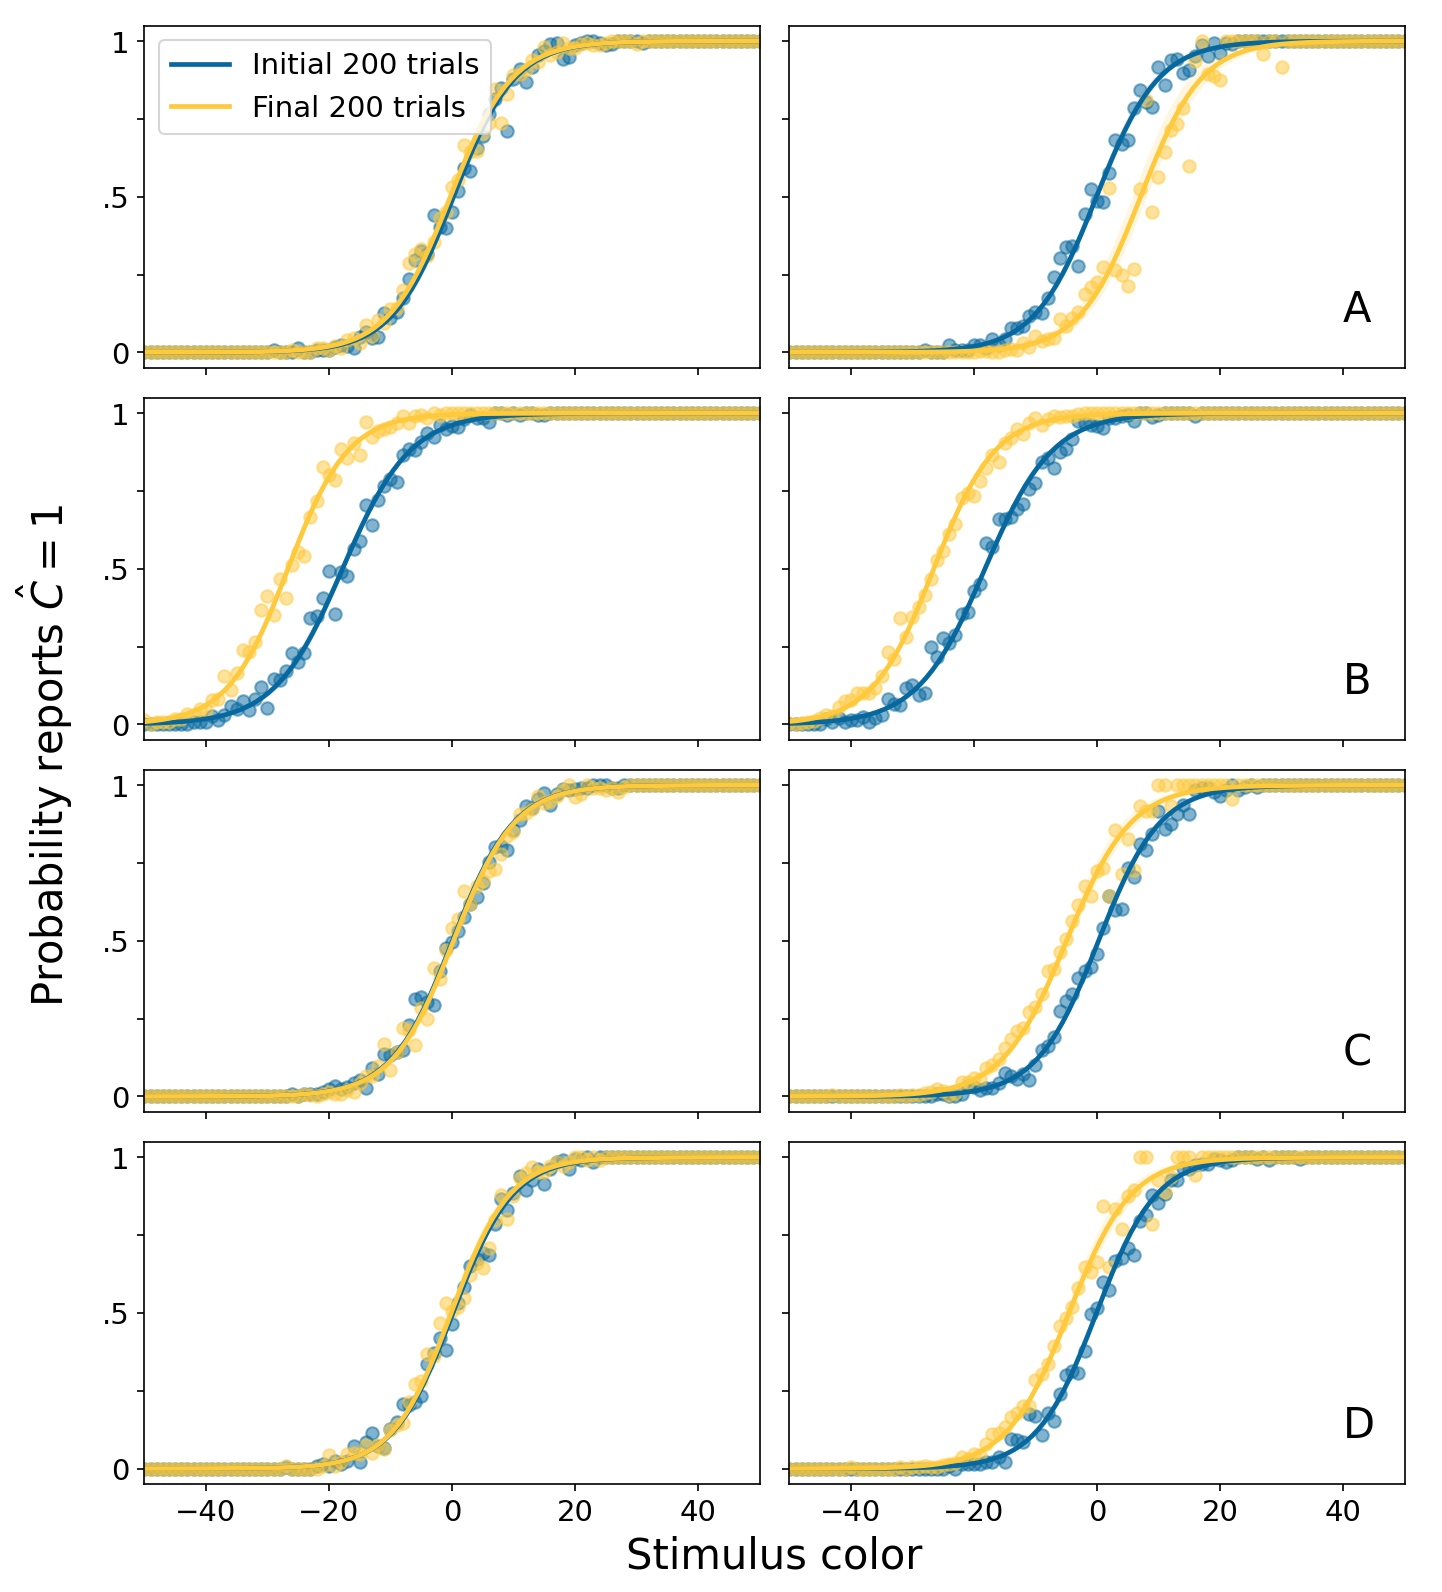

In [174]:
plot_all(observers_1, 'study_1.pdf')

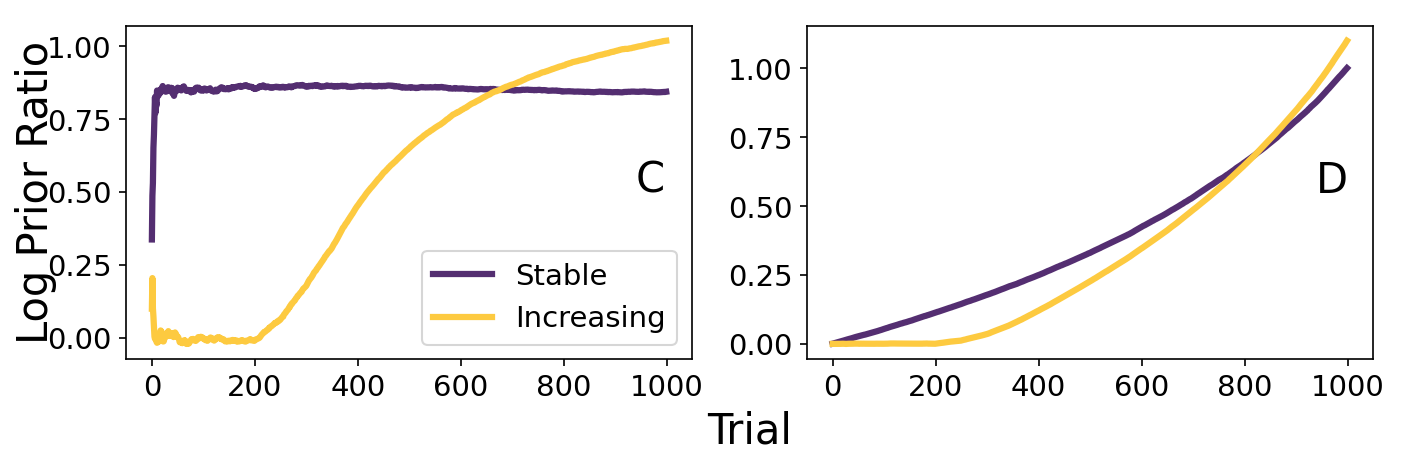

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), sharex=True, dpi=150)

axs = axs.flatten()
axs_ind = 0
alphas = ['C', 'D']
for hyp in observers_x[2:]:
    hyp[0].df['prior'] = np.log(hyp[0].df['prior_b'] / hyp[0].df['prior_p'])
    hyp[1].df['prior'] = np.log(hyp[1].df['prior_b'] / hyp[1].df['prior_p'])
    sns.lineplot(y=hyp[0].df.groupby('trial')['prior'].mean(),
                 x=hyp[0].df['trial'],
                 color="#542e71",
                 ax=axs[axs_ind],
                 linewidth=3)
    sns.lineplot(y=hyp[1].df.groupby('trial')['prior'].mean(),
                 x=hyp[1].df['trial'],
                 color="#fdca40",
                 ax=axs[axs_ind],
                 linewidth=3)
    axs[axs_ind].set_xlabel('')
    axs[axs_ind].set_ylabel('')
    axs[axs_ind].text(0.9,
                      0.5,
                      alphas[axs_ind],
                      fontsize=20,
                      transform=axs[axs_ind].transAxes)
    axs_ind += 1

axs[0].legend(('Stable', 'Increasing'), fontsize=14, loc='lower right')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Trial', fontsize=20)
plt.ylabel('Log Prior Ratio', fontsize=20)

plt.tight_layout()
plt.savefig('lpr_n.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

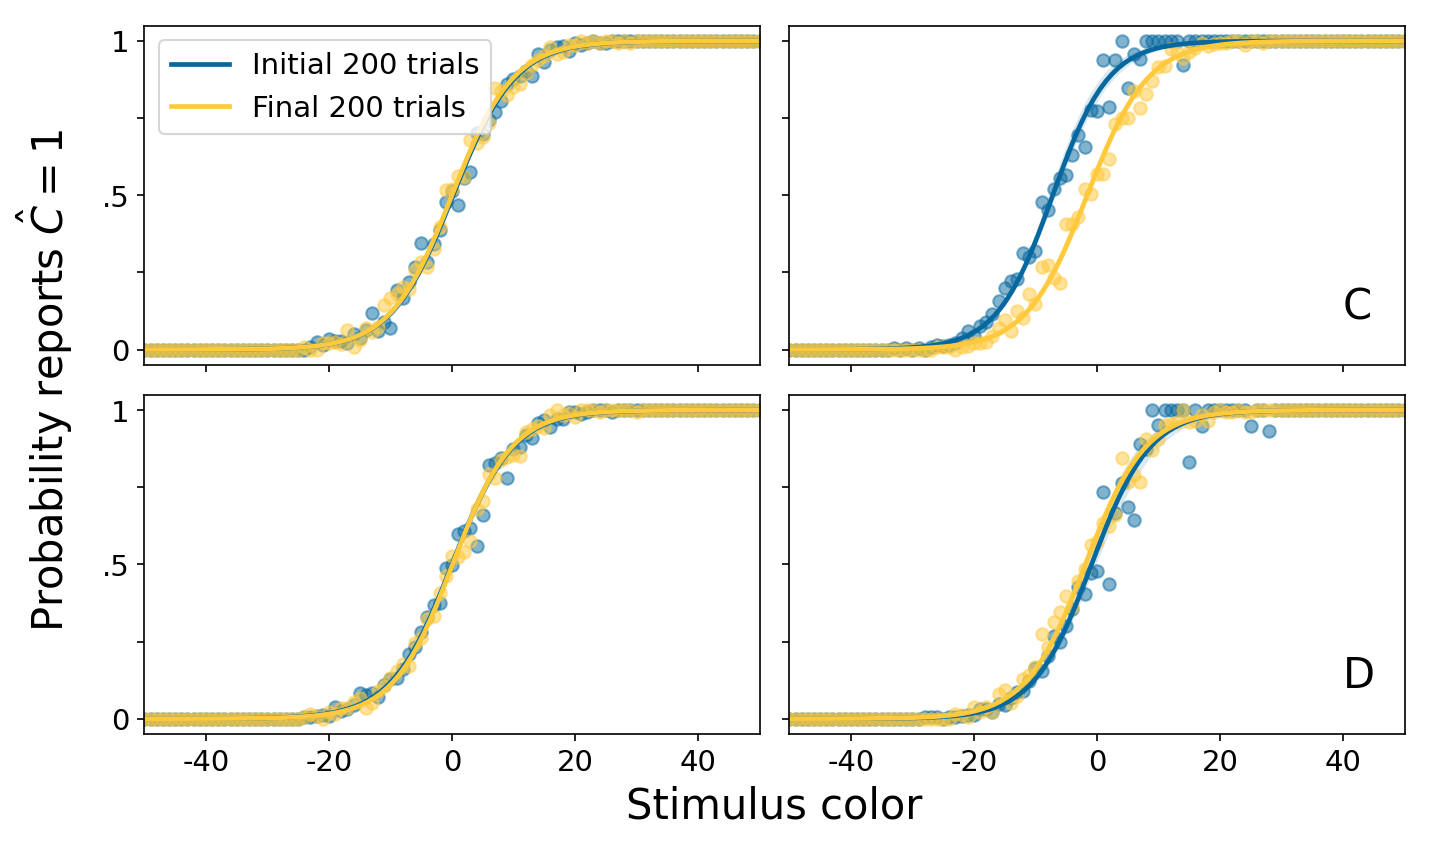

In [195]:
plot_all(observers_5[:2], 'study_5_first.pdf', 2)
plot_all(observers_5[2:], 'study_5_last.pdf', 2, 2)

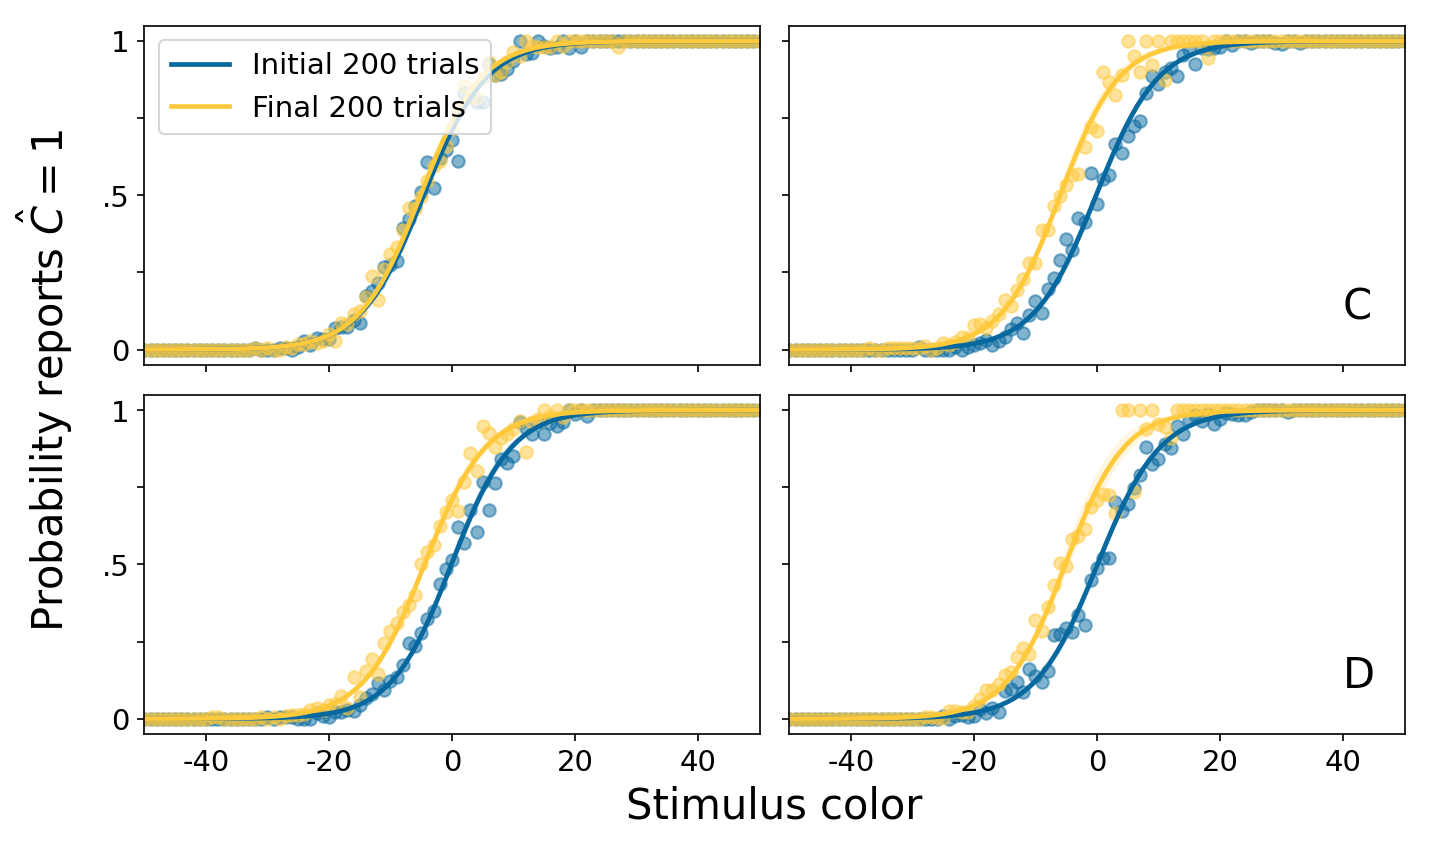

In [196]:
plot_all(observers_x[:2], 'study_n_first.pdf', 2)
plot_all(observers_x[2:], 'study_n_last.pdf', 2, 2)

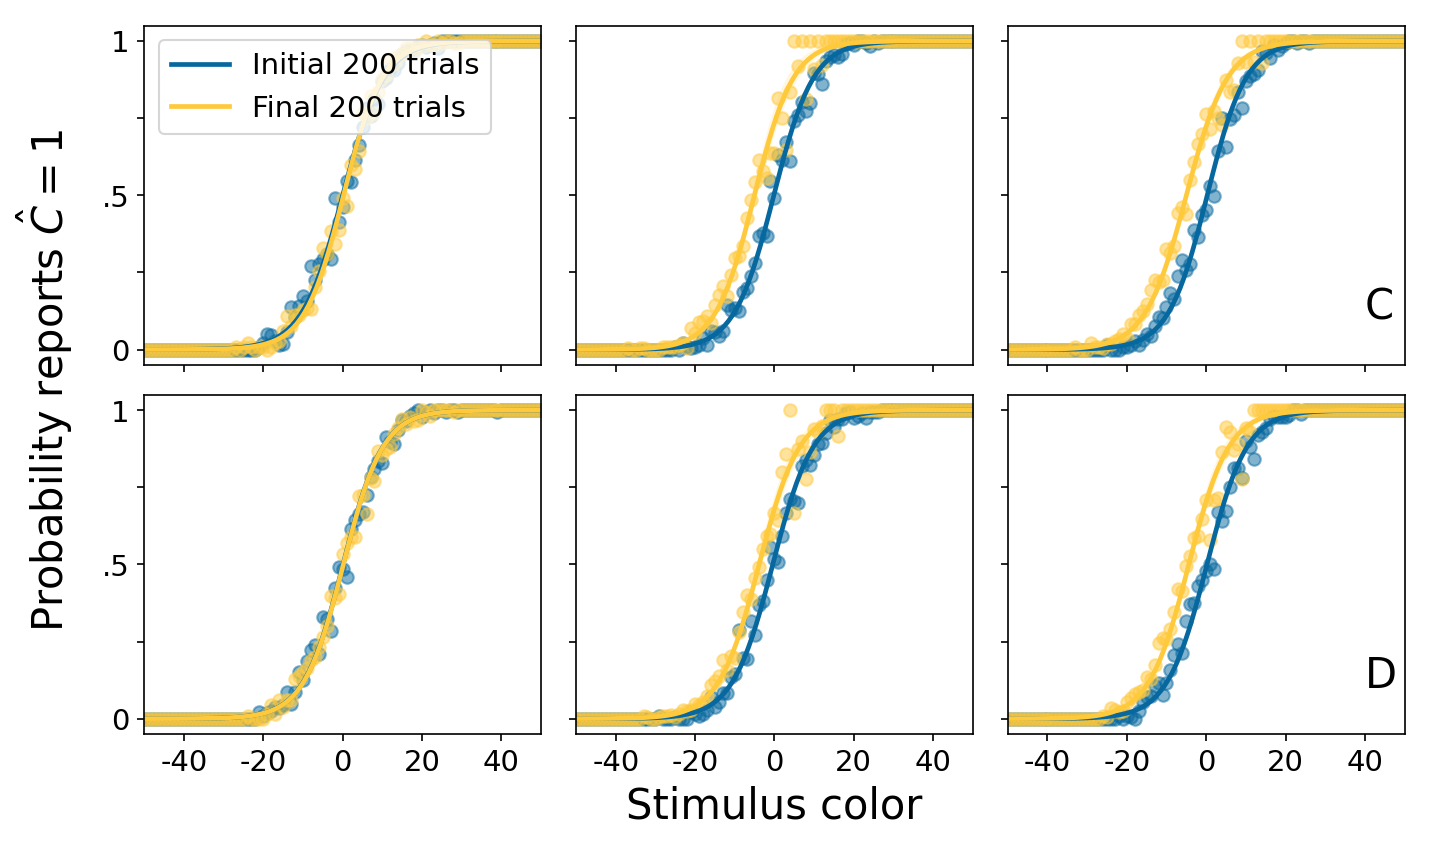

In [197]:
plot_all(observers_4[:2], 'study_4_first.pdf', 2, True, 800)
plot_all(observers_4[2:], 'study_4_last.pdf', 2, 2, True, 800)
plot_all(observers_4, 'study_4.pdf', 4, True, 800)